<a href="https://colab.research.google.com/github/Tharmika2002/Ride-Cancellation-Model-DataX/blob/main/Ride_Cancellation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataX — Ride Cancellation Prediction
**Notebook:** Ride-Cancellation-Model.ipynb   
**Author:** DataX Team

1. **Load data & audit (schema, missingness, class balance)**




In [1]:
# === Setup ===
# !pip install pandas matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)


In [2]:
# === Paths / Config ===

PATH = '/content/drive/MyDrive/Bengaluru Ola.csv'
TARGET_COL = "Booking Status"
RANDOM_STATE = 42


In [3]:
# === Load CSV  ===

df = None

for enc in ["utf-8", "utf-8-sig", "latin-1"]:
    try:
        df = pd.read_csv(PATH, encoding=enc)
        print(f"Successfully loaded with encoding: {enc}")
        break
    except Exception as e:
        print(f"Failed with {enc}: {e}")

assert df is not None, "Could not read CSV — check PATH or encoding."

print("Loaded dataset.")
print("Shape (rows, columns):", df.shape)

df.head(5)


Successfully loaded with encoding: utf-8
Loaded dataset.
Shape (rows, columns): (49999, 21)


,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled by Customer,Reason for Cancelling by Customer,Cancelled Rides by Driver,Reason for Cancelling by Driver,Incomplete Rides,Incomplete Rides Reason,Booking Value,Payment Method,Ride Distance,Driver Ratings,Customer Rating
0,28/01/2024,06:00:00,CNR1721175,Success,329258,Auto,Area-3,Area-2,5.42,18.46,0,NaN,0,NaN,0,NaN,868.06,Wallet,28.5,4.4,4.4
1,26/01/2024,03:00:00,CNR2871422,Cancelled by Driver,201414,Mini,Area-7,Area-6,NaN,NaN,0,NaN,1,The customer was coughing/sick,0,NaN,NaN,NaN,NaN,NaN,NaN
2,15/01/2024,16:00:00,CNR6875935,Cancelled by Driver,301629,Bike,Area-40,Area-24,NaN,NaN,0,NaN,1,Personal & Car related issues,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2/1/2024,22:00:00,CNR6798834,Cancelled by Driver,319684,Prime Sedan,Area-11,Area-24,NaN,NaN,0,NaN,1,The customer was coughing/sick,0,NaN,NaN,NaN,NaN,NaN,NaN
4,30/01/2024,22:00:00,CNR9661713,Incomplete,330283,Bike,Area-41,Area-45,NaN,NaN,0,NaN,0,NaN,1,Other Issue,NaN,NaN,NaN,NaN,NaN


In [4]:
print("\n=== dtypes / info ===")
print(df.info())

schema = pd.DataFrame({
    "column": df.columns,

    "dtype": df.dtypes.astype(str).values,

    "n_unique": [df[c].nunique(dropna=True) for c in df.columns],

    "n_missing": df.isna().sum().values
})

schema = schema.sort_values("column")

schema



=== dtypes / info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               49999 non-null  object 
 1   Time                               49999 non-null  object 
 2   Booking ID                         49999 non-null  object 
 3   Booking Status                     49999 non-null  object 
 4   Customer ID                        49999 non-null  int64  
 5   Vehicle Type                       49999 non-null  object 
 6   Pickup Location                    49999 non-null  object 
 7   Drop Location                      49999 non-null  object 
 8   Avg VTAT                           33484 non-null  float64
 9   Avg CTAT                           33484 non-null  float64
 10  Cancelled  by Customer             49999 non-null  int64  
 11  Reason for Cancelling by Custom

,column,dtype,n_unique,n_missing
9,Avg CTAT,float64,2901,16515
8,Avg VTAT,float64,1901,16515
2,Booking ID,object,49866,0
3,Booking Status,object,4,0
16,Booking Value,float64,30745,16515
10,Cancelled by Customer,int64,2,0
12,Cancelled Rides by Driver,int64,2,0
4,Customer ID,int64,48669,0
20,Customer Rating,float64,21,16515
0,Date,object,31,0


,missing,missing_%
Incomplete Rides Reason,46893,93.79
Reason for Cancelling by Customer,46200,92.40
Reason for Cancelling by Driver,40389,80.78
Avg VTAT,16515,33.03
Payment Method,16515,33.03
Customer Rating,16515,33.03
Ride Distance,16515,33.03
Avg CTAT,16515,33.03
Driver Ratings,16515,33.03
Booking Value,16515,33.03


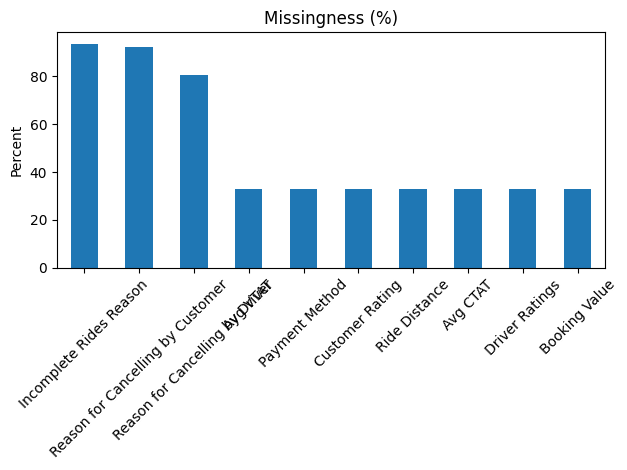

In [5]:
# === Missing Data Audit ===

missing = df.isna().sum().sort_values(ascending=False)

missing_pct = (missing / len(df) * 100).round(2)

audit = pd.DataFrame({
    "missing": missing,
    "missing_%": missing_pct
})

display(audit)


ax = (missing_pct[missing_pct > 0]).plot(
    kind="bar",
    title="Missingness (%)",
    rot=45
)

ax.set_ylabel("Percent")

plt.tight_layout()

plt.show()


,class,count,percent
0,Success,33484,66.97
1,Cancelled by Driver,9610,19.22
2,Cancelled by Customer,3799,7.60
3,Incomplete,3106,6.21


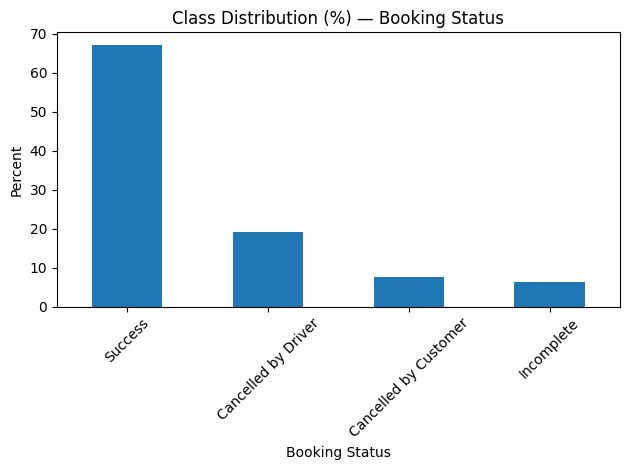

In [6]:
# === Class Distribution Audit ===


assert TARGET_COL in df.columns, f"TARGET_COL '{TARGET_COL}' not found. Check column name."


class_counts = df[TARGET_COL].value_counts(dropna=False)


class_percent = (df[TARGET_COL].value_counts(normalize=True, dropna=False) * 100).round(2)


balance = (
    pd.DataFrame({
        "count": class_counts,
        "percent": class_percent
    })
    .rename_axis("class")
    .reset_index()
)


display(balance)


ax = class_percent.plot(
    kind="bar",
    title=f"Class Distribution (%) — {TARGET_COL}",
    rot=45
)

ax.set_ylabel("Percent")

plt.tight_layout()

plt.show()


In [7]:
# === Preview Normalized Version of 'Booking Status' ===


norm = df[TARGET_COL].astype(str)

norm = norm.str.strip()

norm = norm.str.lower()

value_counts = norm.value_counts()

value_counts.head(10)


,count
Booking Status,
success,33484
cancelled by driver,9610
cancelled by customer,3799
incomplete,3106


2. **Define label (4 classes) & leakage check (booking-time-only features)**

In [8]:
# === Step 3: Define Label & Remove Leakage ===

TARGET_COL = "Booking Status"

print("Target Classes:")
print(df[TARGET_COL].value_counts())

leakage_cols = ["Drop Time", "Trip Duration", "Cancel Reason"]

df_clean = df.drop(columns=[c for c in leakage_cols if c in df.columns])

print("\nRemaining columns after leakage removal:")
print(df_clean.columns.tolist())


Target Classes:
Booking Status
Success                  33484
Cancelled by Driver       9610
Cancelled by Customer     3799
Incomplete                3106
Name: count, dtype: int64

Remaining columns after leakage removal:
['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID', 'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT', 'Avg CTAT', 'Cancelled  by Customer', 'Reason for Cancelling by Customer', 'Cancelled Rides by Driver', 'Reason for Cancelling by Driver', 'Incomplete Rides', 'Incomplete Rides Reason', 'Booking Value', 'Payment Method', 'Ride Distance', 'Driver Ratings', 'Customer Rating']


3. **Feature engineering**

In [9]:
# === Merge Date + Time into one datetime column ===

df["Booking Datetime"] = pd.to_datetime(
    df["Date"].astype(str) + " " + df["Time"].astype(str),
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)

df["hour_of_day"] = df["Booking Datetime"].dt.hour
df["day_of_week"] = df["Booking Datetime"].dt.dayofweek   # Monday=0, Sunday=6
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)

def assign_time_band(h):
    if pd.isna(h):
        return None
    if 5 <= h <= 11:
        return "Morning"
    elif 12 <= h <= 16:
        return "Afternoon"
    elif 17 <= h <= 21:
        return "Evening"
    else:
        return "Night"

df["time_band"] = df["hour_of_day"].apply(assign_time_band)

print(df[["Date", "Time", "Booking Datetime", "hour_of_day", "day_of_week", "is_weekend", "time_band"]].head(10))

         Date      Time    Booking Datetime  hour_of_day  day_of_week  is_weekend  time_band
0  28/01/2024  06:00:00 2024-01-28 06:00:00            6            6           1    Morning
1  26/01/2024  03:00:00 2024-01-26 03:00:00            3            4           0      Night
2  15/01/2024  16:00:00 2024-01-15 16:00:00           16            0           0  Afternoon
3    2/1/2024  22:00:00 2024-01-02 22:00:00           22            1           0      Night
4  30/01/2024  22:00:00 2024-01-30 22:00:00           22            1           0      Night
5  14/01/2024  20:00:00 2024-01-14 20:00:00           20            6           1    Evening
6  17/01/2024  21:00:00 2024-01-17 21:00:00           21            2           0    Evening
7  30/01/2024  00:00:00 2024-01-30 00:00:00            0            1           0      Night
8  22/01/2024  08:00:00 2024-01-22 08:00:00            8            0           0    Morning
9   11/1/2024  05:00:00 2024-01-11 05:00:00            5            3 

In [10]:
# --- Location Features ---


df["Pickup Location"] = df["Pickup Location"].astype("category")
df["Drop Location"]   = df["Drop Location"].astype("category")

pickup_cancel_rate = (
    df.groupby("Pickup Location")["Booking Status"]
    .apply(lambda x: (x != "Success").mean())
)
df["pickup_cancel_rate"] = df["Pickup Location"].map(pickup_cancel_rate)

drop_cancel_rate = (
    df.groupby("Drop Location")["Booking Status"]
    .apply(lambda x: (x != "Success").mean())
)
df["drop_cancel_rate"] = df["Drop Location"].map(drop_cancel_rate)

pair_freq = df.groupby(["Pickup Location", "Drop Location"]).size()
df["pickup_drop_pair_freq"] = list(zip(df["Pickup Location"], df["Drop Location"]))
df["pickup_drop_pair_freq"] = df["pickup_drop_pair_freq"].map(pair_freq)

/tmp/ipython-input-1850174559.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Pickup Location")["Booking Status"]
/tmp/ipython-input-1850174559.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Drop Location")["Booking Status"]
/tmp/ipython-input-1850174559.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pair_freq = df.groupby(["Pickup Location", "Drop Location"]).size()


In [11]:
# --- Ride & Payment Details ---

df["vehicle_type"] = df["Vehicle Type"].astype("category")

df["payment_method"] = df["Payment Method"].apply(
    lambda x: "Cash" if str(x).lower().strip() == "cash" else "Card"
)

if "Package Type" in df.columns:
    df["package_type"] = df["Package Type"].astype("category")

if "Customer Rating" in df.columns:
    df["customer_rating"] = pd.to_numeric(df["Customer Rating"], errors="coerce")
    df["customer_rating"] = df["customer_rating"].fillna(df["customer_rating"].median())

if "Driver Rating" in df.columns:
    df["driver_rating"] = pd.to_numeric(df["Driver Rating"], errors="coerce")
    df["driver_rating"] = df["driver_rating"].fillna(df["driver_rating"].median())


**4. Preprocessing pipeline (impute, encode, scale)**

In [13]:
# === Step 5: Preprocessing pipeline (impute, encode, scale) ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import joblib

TARGET_COL = "Booking Status"
RANDOM_STATE = 42
TEST_SIZE = 0.2

numeric_candidates = [
    "hour_of_day", "day_of_week", "is_weekend",
    "pickup_cancel_rate", "drop_cancel_rate", "pickup_drop_pair_freq",
]
num_features = [c for c in numeric_candidates if c in df.columns]

categorical_candidates = [
    "time_band",
    "Pickup Location",
    "Drop Location",
    "vehicle_type",
    "payment_method",
    "package_type"
]
cat_features = [c for c in categorical_candidates if c in df.columns]

print("Numeric features:", num_features)
print("Categorical features:", cat_features)


X = df[num_features + cat_features].copy()
y = df[TARGET_COL].astype("category")

# ---  Train/Validation split (stratified) ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, " Val shape:", X_val.shape)
print("Class distribution (train):")
print(y_train.value_counts(normalize=True).round(3))


num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=0.01)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ],
        remainder="drop"
)
preprocessor.fit(X_train)

X_train_proc = preprocessor.transform(X_train)
X_val_proc   = preprocessor.transform(X_val)

print("Processed shapes → Train:", X_train_proc.shape, " Val:", X_val_proc.shape)

feature_names = preprocessor.get_feature_names_out()
print("Total processed features:", len(feature_names))
print(feature_names[:25], "...")

import os
os.makedirs("models", exist_ok=True)
joblib.dump(preprocessor, "models/preprocessor.pkl")
print("✅ Saved preprocessor to models/preprocessor.pkl")

Numeric features: ['hour_of_day', 'day_of_week', 'is_weekend', 'pickup_cancel_rate', 'drop_cancel_rate', 'pickup_drop_pair_freq']
Categorical features: ['time_band', 'Pickup Location', 'Drop Location', 'vehicle_type', 'payment_method']
Train shape: (39999, 11)  Val shape: (10000, 11)
Class distribution (train):
Booking Status
Success                  0.670
Cancelled by Driver      0.192
Cancelled by Customer    0.076
Incomplete               0.062
Name: proportion, dtype: float64
Processed shapes → Train: (39999, 119)  Val: (10000, 119)
Total processed features: 119
['num__hour_of_day' 'num__day_of_week' 'num__is_weekend'
 'num__pickup_cancel_rate' 'num__drop_cancel_rate'
 'num__pickup_drop_pair_freq' 'cat__time_band_Afternoon'
 'cat__time_band_Evening' 'cat__time_band_Morning' 'cat__time_band_Night'
 'cat__Pickup Location_Area-1' 'cat__Pickup Location_Area-10'
 'cat__Pickup Location_Area-11' 'cat__Pickup Location_Area-12'
 'cat__Pickup Location_Area-13' 'cat__Pickup Location_Area-14'


5. **Handle class imbalance**

In [14]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# --- Before ---
print("🔹 Class distribution BEFORE balancing:")
print(y_train.value_counts(), "\n")
print((y_train.value_counts(normalize=True) * 100).round(2))

X_train_prep = preprocessor.transform(X_train)

smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy="auto")
X_res, y_res = smote.fit_resample(X_train_prep, y_train)

# --- After ---
print("\n🔹 Class distribution AFTER SMOTE balancing:")
print(y_res.value_counts(), "\n")
print((y_res.value_counts(normalize=True) * 100).round(2))

before = y_train.value_counts().rename("Before")
after  = y_res.value_counts().rename("After (SMOTE)")
comparison = pd.concat([before, after], axis=1).fillna(0).astype(int)
comparison["Before %"] = (comparison["Before"] / len(y_train) * 100).round(2)
comparison["After %"]  = (comparison["After (SMOTE)"] / len(y_res) * 100).round(2)
print("\n📊 Side-by-side comparison:\n", comparison)


🔹 Class distribution BEFORE balancing:
Booking Status
Success                  26787
Cancelled by Driver       7688
Cancelled by Customer     3039
Incomplete                2485
Name: count, dtype: int64 

Booking Status
Success                  66.97
Cancelled by Driver      19.22
Cancelled by Customer     7.60
Incomplete                6.21
Name: proportion, dtype: float64

🔹 Class distribution AFTER SMOTE balancing:
Booking Status
Cancelled by Customer    26787
Cancelled by Driver      26787
Incomplete               26787
Success                  26787
Name: count, dtype: int64 

Booking Status
Cancelled by Customer    25.0
Cancelled by Driver      25.0
Incomplete               25.0
Success                  25.0
Name: proportion, dtype: float64

📊 Side-by-side comparison:
                        Before  After (SMOTE)  Before %  After %
Booking Status                                                 
Success                 26787          26787     66.97     25.0
Cancelled by Driver  


=== Random Forest with SMOTE ===
                       precision    recall  f1-score   support

Cancelled by Customer      0.083     0.072     0.078       760
  Cancelled by Driver      0.228     0.713     0.345      1922
           Incomplete      0.072     0.072     0.072       621
              Success      0.842     0.338     0.483      6697

             accuracy                          0.374     10000
            macro avg      0.306     0.299     0.244     10000
         weighted avg      0.618     0.374     0.400     10000

Macro-F1: 0.2443662443062198


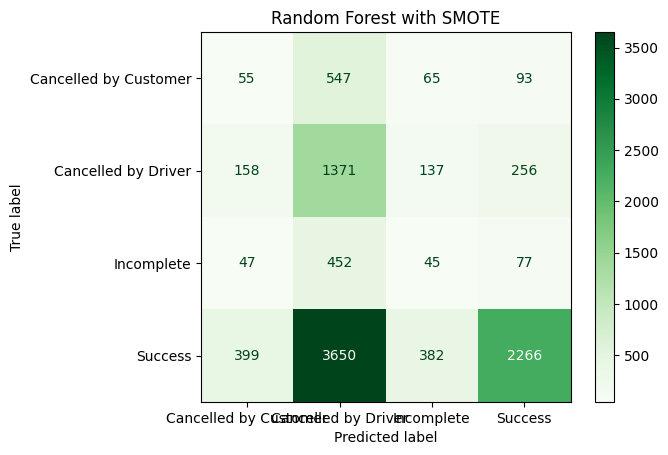

✅ Model exported to random_forest_smote_model.pkl (compressed)


In [15]:
 # -------------------------------
#  Random Forest with SMOTE (ensemble model)
# -------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
import joblib

RANDOM_STATE = 42

try:
    ohe = preprocessor.named_transformers_["cat"].named_steps["encoder"]
    if hasattr(ohe, "sparse_output"):
        if ohe.sparse_output:
            ohe.sparse_output = False
    else:
        if ohe.sparse:
            ohe.sparse = False
except Exception:
    pass

preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)

smote = SMOTE(
    random_state=RANDOM_STATE,
    k_neighbors=3,
    sampling_strategy="auto"
)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)


rf_model = RandomForestClassifier(
    n_estimators=120,
    max_depth=12,
    min_samples_leaf=5,
    max_features="sqrt",
    ccp_alpha=0.001,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)

rf_model.fit(X_resampled, y_resampled)

X_val_processed = preprocessor.transform(X_val)
y_pred_rf = rf_model.predict(X_val_processed)

print("\n=== Random Forest with SMOTE ===")
print(classification_report(y_val, y_pred_rf, digits=3))
print("Macro-F1:", f1_score(y_val, y_pred_rf, average="macro"))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_rf, cmap="Greens")
plt.title("Random Forest with SMOTE")
plt.show()


bundle = {"preprocessor": preprocessor, "model": rf_model}

joblib.dump(bundle, "random_forest_smote_model.pkl", compress=("xz", 3))
print("✅ Model exported to random_forest_smote_model.pkl (compressed)")
